# NFL Player Clustering By Position: QBs

In [338]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## Load in data

In [339]:
NFL_QB_Identifiers = pd.read_csv("C:/Users/jakel/OneDrive/Desktop/GitHub/NFL-Player-Clustering/filtered-data/NFL-QB-Identifiers.csv")
NFL_QB_Identifiers.drop(columns=['Unnamed: 0'], inplace=True)
NFL_QB_Identifiers.head()

,Player,Team
0,Joe Burrow,CIN
1,Jared Goff,DET
2,Baker Mayfield,TAM
3,Geno Smith,SEA
4,Sam Darnold,MIN


In [340]:
NFL_QB_Features = pd.read_csv("C:/Users/jakel/OneDrive/Desktop/GitHub/NFL-Player-Clustering/filtered-data/NFL-QB-Features.csv")
NFL_QB_Features.drop(columns=['Unnamed: 0'], inplace=True)
NFL_QB_Features.head()

,Age,G,GS,Cmp%,Yds,TD,TD%,Int,Int%,1D,...,AY/A,Y/C,Y/G,Rate,QBR,NY/A,ANY/A,4QC,GWD,QB-Wins
0,28.0,17.0,17.0,70.6,4918.0,43.0,6.6,9.0,1.4,253.0,...,8.24,10.7,289.3,108.5,74.7,6.63,7.28,1.0,2.0,9
1,30.0,17.0,17.0,72.4,4629.0,37.0,6.9,12.0,2.2,236.0,...,8.96,11.9,272.3,111.8,68.4,7.71,8.06,4.0,4.0,15
2,29.0,17.0,17.0,71.4,4500.0,41.0,7.2,16.0,2.8,224.0,...,8.07,11.1,264.7,106.8,61.6,6.97,7.13,2.0,2.0,10
3,34.0,17.0,17.0,70.4,4320.0,21.0,3.6,15.0,2.6,209.0,...,7.03,10.6,254.1,93.2,53.8,6.34,5.93,4.0,4.0,10
4,27.0,17.0,17.0,66.2,4319.0,35.0,6.4,12.0,2.2,207.0,...,8.22,12.0,254.1,102.5,60.4,6.72,6.99,3.0,5.0,14


## Use PCA to reduce dimensionality

In [341]:
scaler = StandardScaler()
qb_features_scaled = scaler.fit_transform(NFL_QB_Features)

In [342]:
pca = PCA(n_components=4)
qb_features_pca = pca.fit_transform(qb_features_scaled)

print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))

[0.49901136 0.14430403 0.09801523 0.07210534] 0.8134359611414516


In [343]:
# Save for later when we analyze PCs
loadings = pd.DataFrame(
    pca.components_,
    columns=NFL_QB_Features.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

In [344]:
top_features_per_pc = {}
for i in range(4):  # PC1 to PC4
    component = loadings.iloc[i]
    top_features = component.abs().sort_values(ascending=False).head(3)
    descriptions = [f"{feat} ({component[feat]:.2f})" for feat in top_features.index]
    top_features_per_pc[f"PC{i+1}"] = "\n".join(descriptions)

Using 5 component PCA, 84.7% of total variability explained, reduced dimensions from 25 to 5.

## Cluster QBs using K Means

In [345]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(qb_features_pca)

In [346]:
NFL_QB_Identifiers['Cluster'] = clusters
NFL_QB_Features['Cluster'] = clusters

## Analyze Principal Components

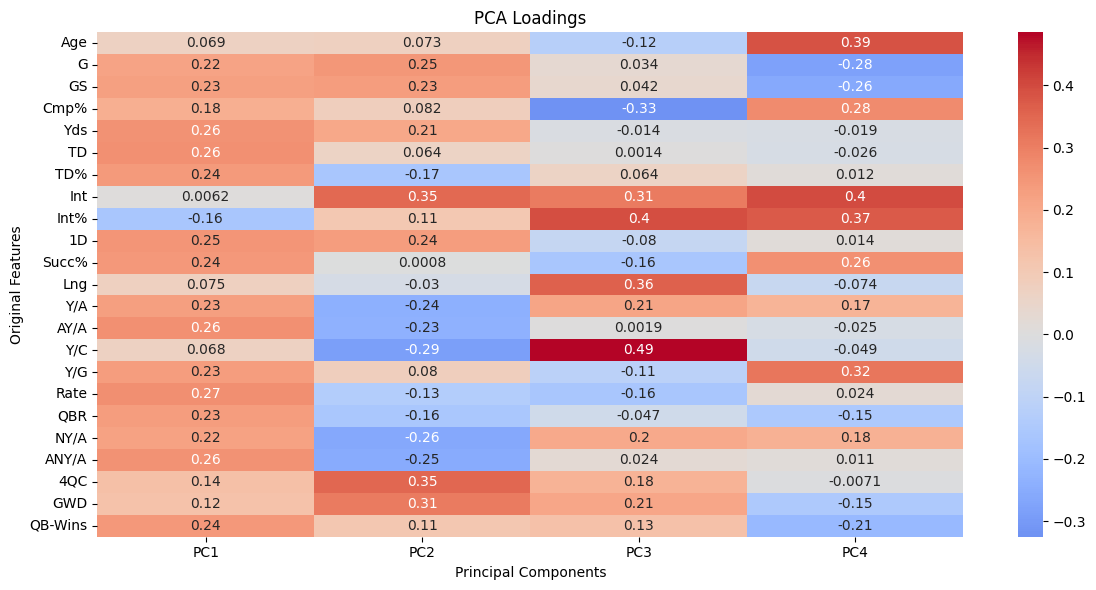

In [347]:
plt.figure(figsize=(12, 6))
sns.heatmap(loadings.T, cmap='coolwarm', center=0, annot=True)
plt.title("PCA Loadings")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.tight_layout()
plt.show()

## Analyze Clusters

In [348]:
pca_df = pd.DataFrame(qb_features_pca[:, :4], columns=['PC1', 'PC2', 'PC3', 'PC4'])

pca_df['Player'] = NFL_QB_Identifiers['Player'].values
pca_df['Team'] = NFL_QB_Identifiers['Team'].values
pca_df['Cluster'] = clusters


In [349]:
pcs = ['PC1', 'PC2', 'PC3', 'PC4']
traces = []
buttons = []

# Track trace visibility layout
trace_visibility_templates = []

# Generate only unique (non-flipped) PC pairs
pc_pairs = [(pcs[i], pcs[j]) for i in range(len(pcs)) for j in range(i+1, len(pcs))]

for idx, (x_pc, y_pc) in enumerate(pc_pairs):
    visible = (idx == 0)

    trace = go.Scatter(
        x=pca_df[x_pc],
        y=pca_df[y_pc],
        mode='markers+text',
        text=pca_df['Player'],
        textposition='top center',
        marker=dict(size=12, color=pca_df['Cluster'], colorscale='Viridis'),
        hovertemplate='<b>%{text}</b><br>Team: %{customdata[0]}<br>Cluster: %{marker.color}<extra></extra>',
        customdata=pca_df[['Team']],
        showlegend=False,
        visible=visible,
        name=f"{x_pc} vs {y_pc}"
    )

    traces.append(trace)

    # Create visibility array: only one trace visible at a time
    visibility = [i == idx for i in range(len(pc_pairs))]

    buttons.append(dict(
        label=f"{x_pc} vs {y_pc}",
        method="update",
        args=[
            {"visible": visibility},
            {"xaxis.title.text": x_pc, "yaxis.title.text": y_pc}
        ]
    ))

# Build the figure
fig = go.Figure(data=traces)

fig.update_layout(
    title="NFL QB Clusters on Selectable Principal Components",
    width=900,
    height=700,
    xaxis_title=pc_pairs[0][0],
    yaxis_title=pc_pairs[0][1],
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=0.75,
        xanchor="center",
        y=1.15,
        yanchor="top"
    )],
    margin=dict(t=100, r=275)
)

for i, (pc, text) in enumerate(top_features_per_pc.items()):
    fig.add_annotation(
        x=1.5,  # outside the right side of the plot
        y=1 - (i * 0.25),  # stacked vertically
        xref='paper',
        yref='paper',
        text=f"<b>{pc}</b><br>{text}",
        showarrow=False,
        align='left',
        font=dict(size=12),
        bordercolor='black',
        borderwidth=1,
        bgcolor='white',
        opacity=0.9
    )


fig.show()

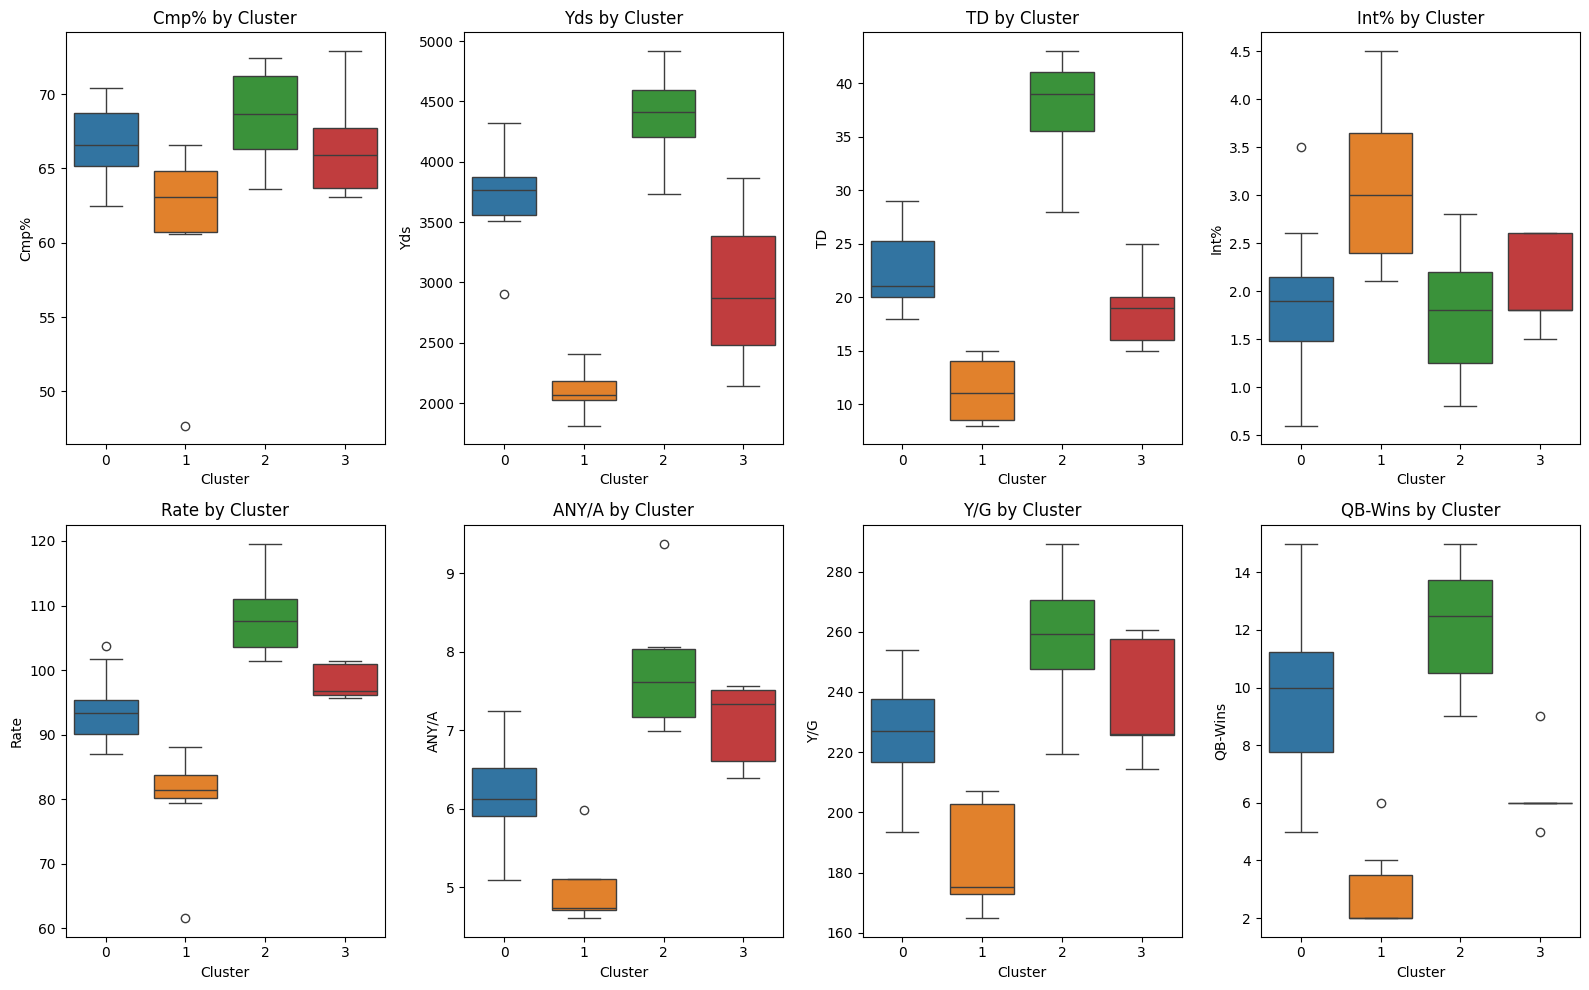

In [350]:
stats_to_plot = ['Cmp%', 'Yds', 'TD', 'Int%', 'Rate', 'ANY/A', 'Y/G', 'QB-Wins']

plt.figure(figsize=(16, 10))

for i, stat in enumerate(stats_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='Cluster', y=stat, data=NFL_QB_Features, hue='Cluster', palette='tab10', legend=False)
    plt.title(f'{stat} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(stat)

plt.tight_layout()
plt.show()
